In [127]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import xgboost as xgb
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, classification_report, accuracy_score

In [112]:
train_data = pd.read_csv("/kaggle/input/spaceship-titanic/train.csv")
train_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [113]:
train_data.isnull().sum()/len(train_data) * 100

PassengerId     0.000000
HomePlanet      2.312205
CryoSleep       2.496261
Cabin           2.289198
Destination     2.093639
Age             2.059128
VIP             2.335212
RoomService     2.082135
FoodCourt       2.105142
ShoppingMall    2.392730
Spa             2.105142
VRDeck          2.162660
Name            2.300702
Transported     0.000000
dtype: float64

## New we should clean the data

In [114]:
train_data.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported'],
      dtype='object')

In [115]:
train_data["Destination"].unique()

array(['TRAPPIST-1e', 'PSO J318.5-22', '55 Cancri e', nan], dtype=object)

## Some columns are not so essential so we can drop them. They are RoomService, FoodCourt, ShoppingMall, Spa, VRDeck.

In [116]:
class drop_MVR(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = X.dropna()
        return X

In [117]:
class Total_expenditure(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X['TotalSpending'] = X[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1)
        X = X.drop(['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'], axis=1)
        return X


In [118]:
class Categorical_cols(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        categorical_cols = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Deck', 'Side']
        for col in categorical_cols:
            X[col] = LabelEncoder().fit_transform(X[col])
        return X

In [119]:
class Cabin(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X[['Deck', 'Cabin_num', 'Side']] = X['Cabin'].str.split('/', expand=True)
        return X


In [120]:
class Transported(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X['Transported'] = X['Transported'].astype(int)
        return X

In [121]:
class drop_col(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        cols = ['Name', 'Cabin', 'Cabin_num', 'PassengerId']
        X = X.drop(cols, axis=1)
        return X

In [122]:
pipeline = Pipeline(
    [
        ("Dropping Rows", drop_MVR()),
        ("Total Expenditure", Total_expenditure()),
        ("Cabin divide", Cabin()),
        ("Categorical_cols", Categorical_cols()),
        ("Dropping Columns", drop_col()),
        ("Transported", Transported())
    ]
)

In [123]:
prepared_train_data = pipeline.fit_transform(train_data)
prepared_train_data.head(10)

<ipython-input-117-cdd594db5790>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['TotalSpending'] = X[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1)


,HomePlanet,CryoSleep,Destination,Age,VIP,Transported,TotalSpending,Deck,Side
0,1,0,2,39.0,0,0,0.0,1,0
1,0,0,2,24.0,0,1,736.0,5,1
2,1,0,2,58.0,1,0,10383.0,0,1
3,1,0,2,33.0,0,0,5176.0,0,1
4,0,0,2,16.0,0,1,1091.0,5,1
5,0,0,1,44.0,0,1,774.0,5,0
6,0,0,2,26.0,0,1,1584.0,5,1
8,0,0,2,35.0,0,1,1018.0,5,1
9,1,1,0,14.0,0,1,0.0,1,0
11,1,0,0,45.0,0,1,8157.0,1,0


In [125]:
X = prepared_train_data.drop("Transported", axis=1)
y = prepared_train_data["Transported"]

## Now we should train the data

In [126]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.87      0.78       653
           1       0.84      0.66      0.74       669

    accuracy                           0.76      1322
   macro avg       0.78      0.77      0.76      1322
weighted avg       0.78      0.76      0.76      1322



/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


<Figure size 1000x600 with 0 Axes>

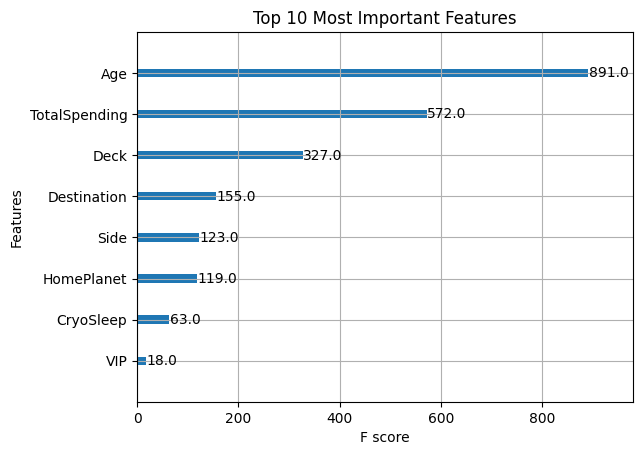

In [128]:
model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    random_state=42
)

model.fit(
    X_train, 
    y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='logloss',
    early_stopping_rounds=20,
    verbose=False
)

val_preds = model.predict(X_val)
print("\nClassification Report:")
print(classification_report(y_val, val_preds))

plt.figure(figsize=(10, 6))
xgb.plot_importance(model, max_num_features=10, title='Top 10 Most Important Features')
plt.show()

## Now generate predictions

In [134]:
test_pipeline = Pipeline(
    [
        ("Total Expenditure", Total_expenditure()),
        ("Cabin divide", Cabin()),
        ("Categorical_cols", Categorical_cols()),
        ("Dropping Columns", drop_col())
    ]
)
test_path = "/kaggle/input/spaceship-titanic/test.csv"
test_data = pd.read_csv(test_path)
prepared_test_data = test_pipeline.fit_transform(test_data)
test_preds = model.predict(prepared_test_data)

submission = pd.DataFrame({
    'PassengerId': test_data['PassengerId'],
    'Transported': test_preds.astype(bool)
})

submission.to_csv('submission.csv', index=False)